# Environment

In [1]:
import torch
import matplotlib.pyplot as plt
from helpers.plot import compare_audios
from helpers.audio_utils import trim_audio
from helpers.path_utils import get_base_dir
from helpers.find_trigger import FindTrigger

AUDIO_NAME = "000-20240910-1753.wav"
# AUDIO_NAME = "001-20240909-1746.wav"
# AUDIO_NAME = "002-20240918-1835.wav"
# AUDIO_NAME = "003-20240918-1841.wav"
# AUDIO_NAME = "004-20240924-0014.wav"

mobile_dir = get_base_dir().joinpath("data", "mobile", "last-trigger", AUDIO_NAME)
stethos_dir = get_base_dir().joinpath("data", "stethos", "last-trigger", AUDIO_NAME)

ft = FindTrigger()

mobile, stethos, sample_rate = ft.load_recordings(str(mobile_dir), str(stethos_dir))
mobile.shape, stethos.shape, sample_rate

(torch.Size([1, 494000]), torch.Size([1, 480000]), 4000)

# Snippet to find the last trigger

In [2]:
START_AT = None
END_AT = 11

mobile_snippet = trim_audio(mobile, sample_rate, START_AT, END_AT)
stethos_snippet = trim_audio(stethos, sample_rate, START_AT, END_AT)

mobile.shape, mobile_snippet.shape

(torch.Size([1, 494000]), torch.Size([1, 44000]))

# Find the las trigger

## Mobile recording

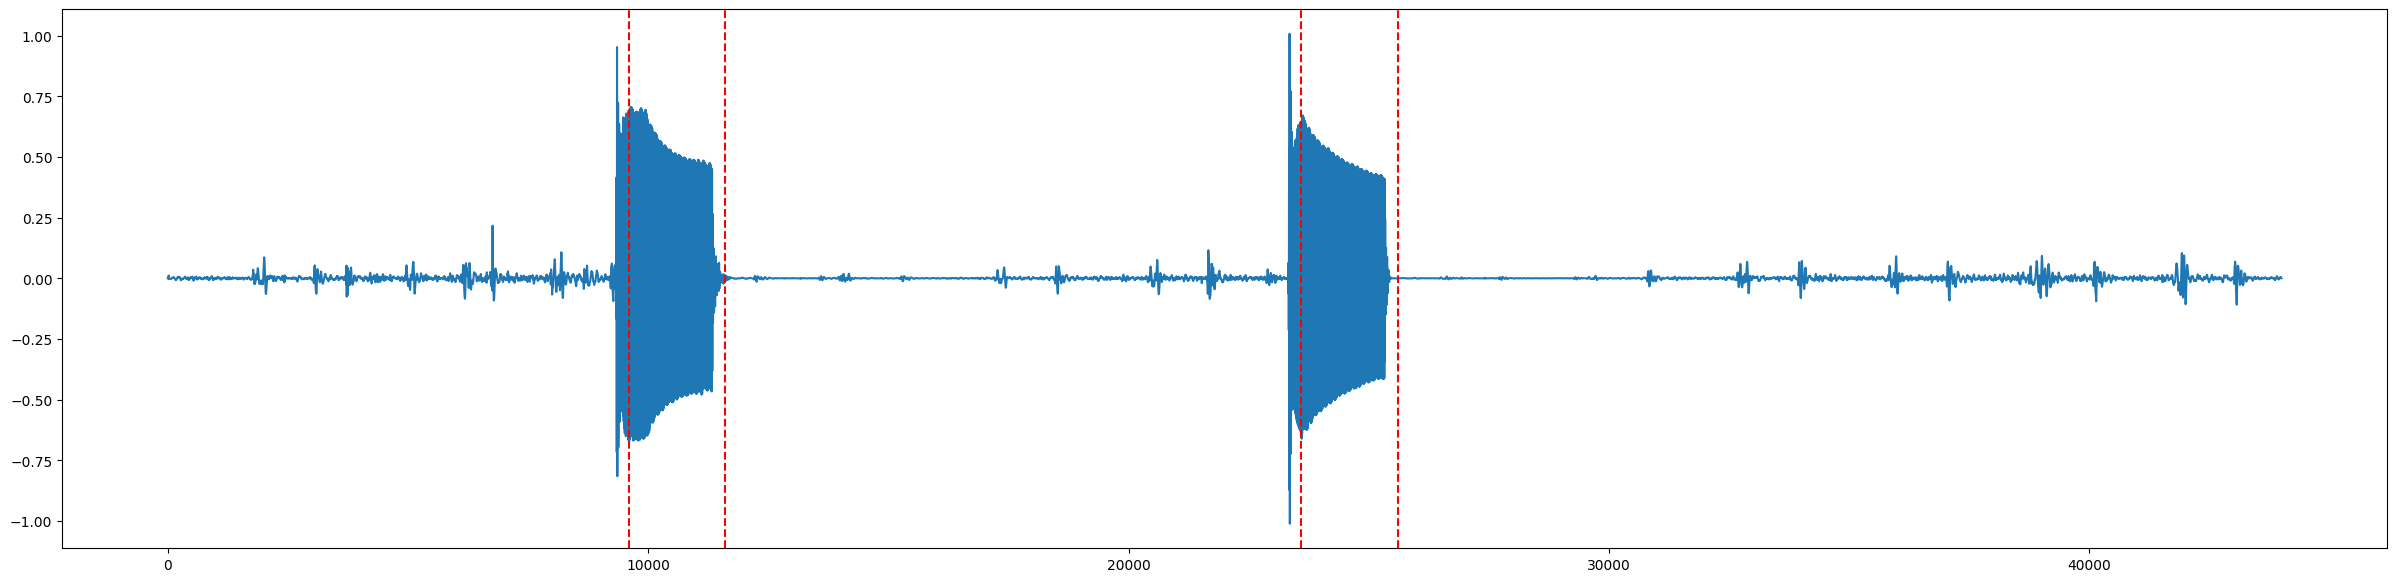

In [3]:
SYNTHETIC_FREQ = 360
DOWNSAMPLE_FACTOR = 400
SIGMA_SMOOTH = 1
PEAKS_HEIGHT = 0.3
PEAKS_PROMINENCE = 0.0001

mobile_triggers = ft.find_trigger_peaks(
    audio=mobile_snippet,
    sample_rate=sample_rate,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
)

plt.figure(figsize=(30, 7))
plt.plot(mobile_snippet.squeeze())

for peak in mobile_triggers:
    plt.axvline(x=peak, color="red", linestyle="--")

plt.show()

## Stethoscope recording

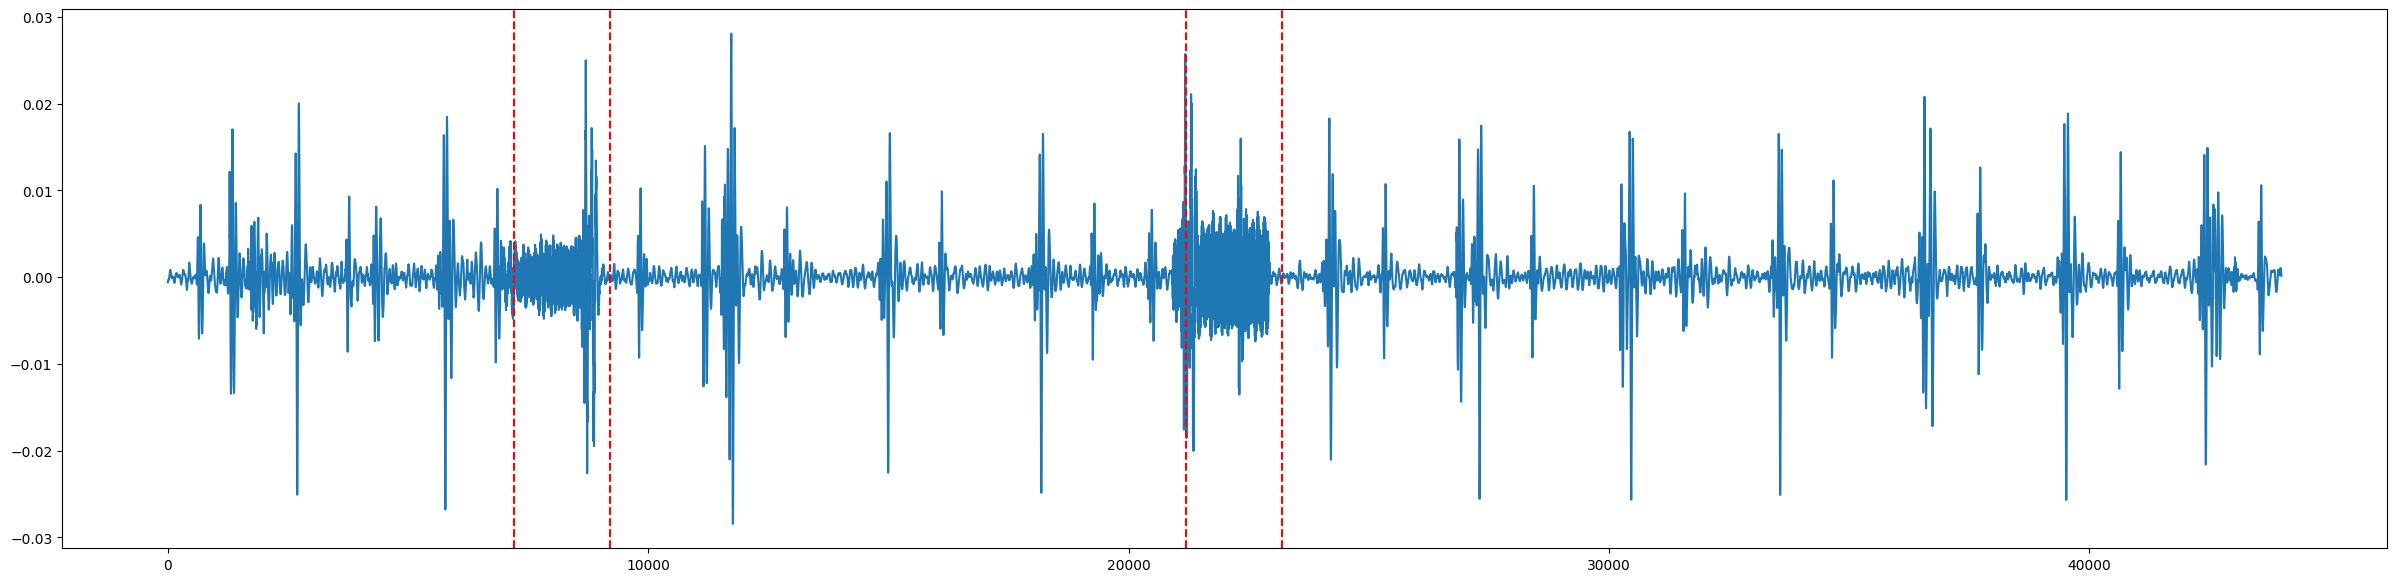

In [4]:
stethos_triggers = ft.find_trigger_peaks(
    audio=stethos_snippet,
    sample_rate=sample_rate,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
)

plt.figure(figsize=(30, 7))
plt.plot(stethos_snippet.squeeze())

for peak in stethos_triggers:
    plt.axvline(x=peak, color="red", linestyle="--")

plt.show()

# Match last trigger

In [5]:
SNIPPET_SECS = 11

mobile_match, stethos_match = ft.match_last_trigger(
    mobile_audio=mobile,
    stethos_audio=stethos,
    sample_rate=sample_rate,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
    snippet_secs=SNIPPET_SECS,
)

In [6]:
# # Manual match mobile offset :)
# mobile_match = mobile_match[:, offset_samples:].clone()
# stethos_match = stethos_match[:, :mobile_match.shape[-1]].clone()

In [7]:
# # Manual match stethos offset :)
# stethos_match = stethos_match[:, offset_samples:].clone()
# mobile_match = mobile_match[:, :stethos_match.shape[-1]].clone()

# Snippet to visualize match

torch.Size([1, 456800]) torch.Size([1, 8000])


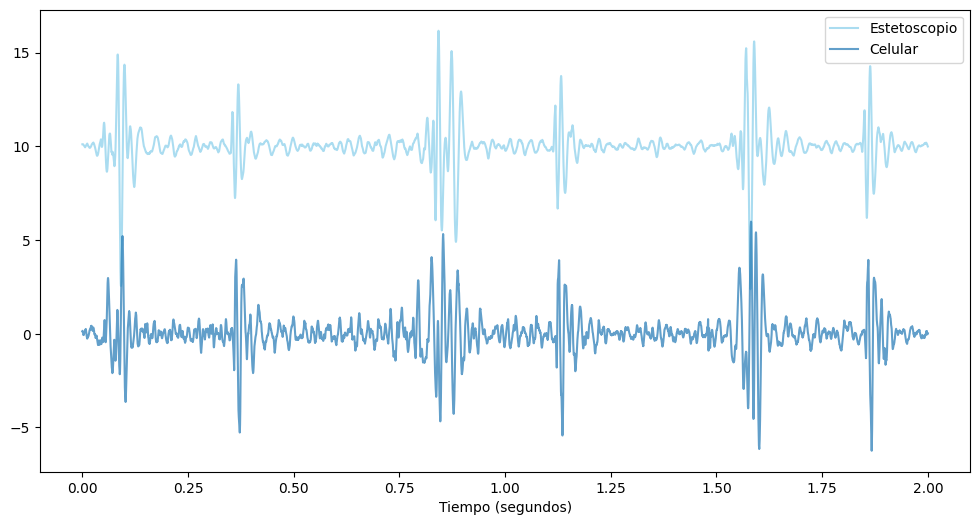

In [8]:
VIZ_START_AT = 2.5
VIZ_END_AT = VIZ_START_AT + 2

mobile_match_snippet = trim_audio(mobile_match, sample_rate, VIZ_START_AT, VIZ_END_AT)
stethos_match_snippet = trim_audio(stethos_match, sample_rate, VIZ_START_AT, VIZ_END_AT)

print(mobile_match.shape, mobile_match_snippet.shape)

compare_audios(
    mobile_match_snippet.squeeze(),
    stethos_match_snippet.squeeze(),
    sample_rate,
    offset=10,
)

Manual match :)

In [9]:
# # Mobile Offset
# OFFSET_SECS = 0.02
# offset_samples = int(OFFSET_SECS * sample_rate)

# aux_mobile = mobile_match_snippet[:, offset_samples:].squeeze()
# aux_stethos = stethos_match_snippet[:, :aux_mobile.shape[-1]].squeeze()

# compare_audios(aux_mobile, aux_stethos, sample_rate, offset=10)

In [10]:
# # Stethos Offset
# OFFSET_SECS = 0.028
# offset_samples = int(OFFSET_SECS * sample_rate)

# aux_stethos = stethos_match_snippet[:, offset_samples:].squeeze()
# aux_mobile = mobile_match_snippet[:, :aux_stethos.shape[-1]].squeeze()

# compare_audios(aux_mobile, aux_stethos, sample_rate, offset=10)

# Save match tuple as .pt

In [11]:
OUTPUT_DIR = get_base_dir().joinpath("data", "model", "original")

ft.save_match(mobile_match, stethos_match, sample_rate, OUTPUT_DIR, AUDIO_NAME)

File 'C:\Users\efrai\OneDrive\Desktop\EF\Education\MCC_UAG\Tesis\coratech\data\model\original\000-20240910-1753.pt' was saved succesfully!


# Validate the same shape for both Tensors

In [12]:
mobile_final, stethos_final, sample_rate = torch.load(
    OUTPUT_DIR.joinpath(AUDIO_NAME.replace(".wav", ".pt"))
)

mobile_final.shape, stethos_final.shape, sample_rate

(torch.Size([1, 456800]), torch.Size([1, 456800]), 4000)